## UMAP the decoder weights of SAEs
We can concat the weights of multiple models and umap them together to try and get a shared projection.


In [3]:
# pip install latentsae pandas numpy umap-learn tqdm matplotlib
from latentsae.sae import Sae
import numpy as np
import pandas as pd
import umap
import tqdm
import os

In [4]:
device = "cpu"

In [5]:
sae_a = "64_32"
sae_b = "64_128"
# sae_id = "128_32"
# sae_id = "64_64"

In [6]:
model_a = Sae.load_from_hub("enjalot/sae-nomic-text-v1.5-FineWeb-edu-100BT", sae_a, device=device)
model_b = Sae.load_from_hub("enjalot/sae-nomic-text-v1.5-FineWeb-edu-100BT", sae_b, device=device)

Fetching 2 files: 100%|██████████| 2/2 [00:15<00:00,  7.75s/it]


In [7]:
name_a = f"NOMIC_FWEDU_{round(model_a.num_latents/1000)}k"
name_b = f"NOMIC_FWEDU_{round(model_b.num_latents/1000)}k"

In [8]:
weights_a = [model_a.W_dec[i].detach().cpu().numpy() for i in range(model_a.W_dec.size(0))]
weights_b = [model_b.W_dec[i].detach().cpu().numpy() for i in range(model_b.W_dec.size(0))]
weights = np.concatenate([weights_a, weights_b], axis=0)

In [97]:
reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [98]:
xy = reducer.fit_transform(weights)

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Sat Aug 24 10:20:47 2024 Construct fuzzy simplicial set
Sat Aug 24 10:20:47 2024 Finding Nearest Neighbors
Sat Aug 24 10:20:47 2024 Building RP forest with 23 trees
Sat Aug 24 10:20:53 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	Stopping threshold met -- exiting after 7 iterations
Sat Aug 24 10:26:09 2024 Finished Nearest Neighbor Search
Sat Aug 24 10:26:11 2024 Construct embedding


Epochs completed:   2%| ▏          3/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  10%| █          21/200 [00:06]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [00:14]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [00:22]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [00:29]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [00:37]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [00:46]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [00:54]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [01:02]

	completed  160  /  200 epochs


Epochs completed:  90%| █████████  181/200 [01:10]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [01:18]


Sat Aug 24 10:27:53 2024 Finished embedding


In [99]:
min_values = np.min(xy, axis=0)
max_values = np.max(xy, axis=0)

# Scale the embeddings to the range [0, 1]
xy = (xy - min_values) / (max_values - min_values)

# Scale the embeddings to the range [-1, 1]
xy = 2 * xy - 1

POINT SIZE 5 for 122880 points


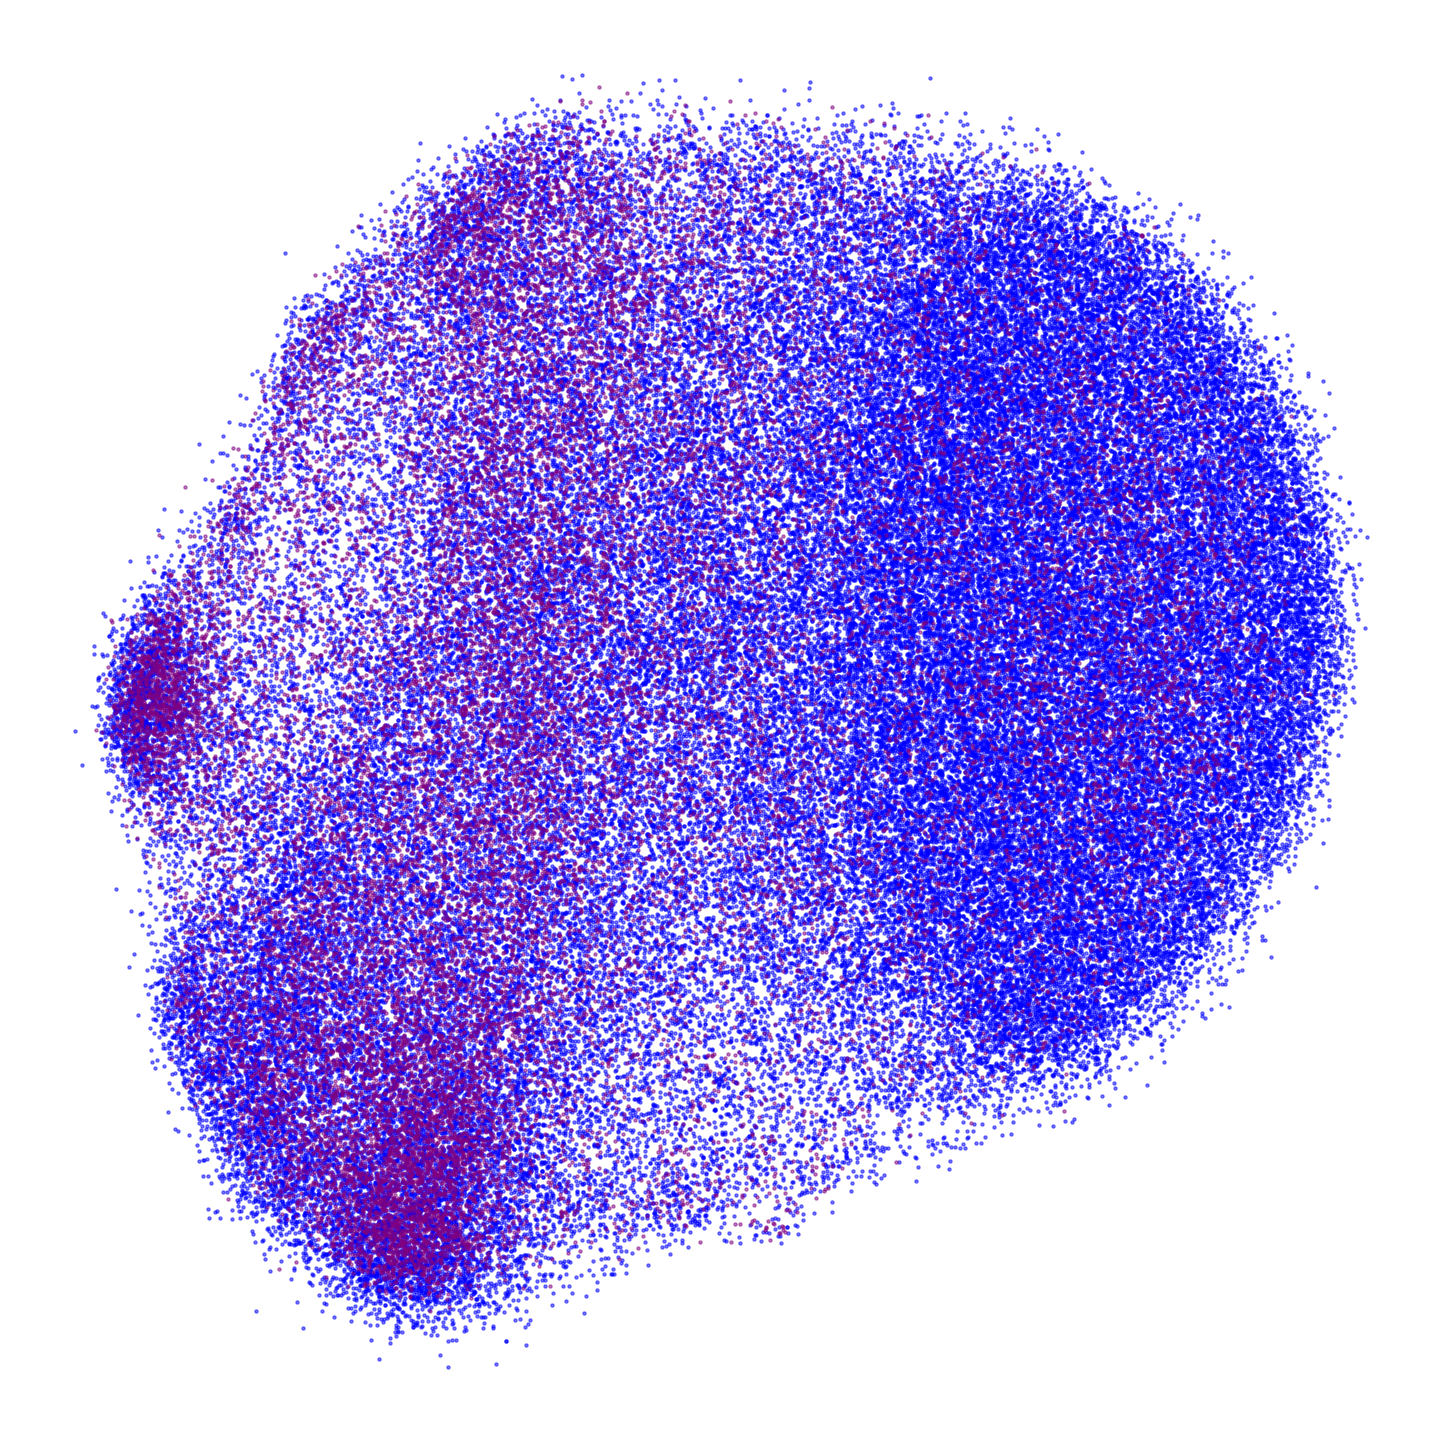

In [102]:
# generate a scatterplot of the umap embeddings and save it to a file
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14.22, 14.22))  # 1024px by 1024px at 72 dpi
point_size = 5
print("POINT SIZE", point_size, "for", xy.shape[0], "points")
plt.scatter(xy[len(weights_a):, 0], xy[len(weights_a):, 1], s=point_size, alpha=0.5, label=name_b, color="blue")
plt.scatter(xy[:len(weights_a), 0], xy[:len(weights_a), 1], s=point_size, alpha=0.5, label=name_a, color="purple")
plt.axis('off')  # remove axis
plt.gca().set_position([0, 0, 1, 1])  # remove margins
plt.show()

In [101]:
df_a = pd.DataFrame(xy[:len(weights_a)], columns=['x', 'y'])
df_b = pd.DataFrame(xy[len(weights_a):], columns=['x', 'y'])


if not os.path.exists("data"):
    os.makedirs("data")
df_a.to_parquet(f"data/umap-{name_a}.parquet")
df_b.to_parquet(f"data/umap-{name_b}.parquet")

In [9]:
reducer1d = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_components=1,
    verbose=True,
)

In [104]:
order = reducer1d.fit_transform(weights)
order.shape

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_components=1, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Sat Aug 24 14:28:29 2024 Construct fuzzy simplicial set
Sat Aug 24 14:28:29 2024 Finding Nearest Neighbors
Sat Aug 24 14:28:29 2024 Building RP forest with 23 trees
Sat Aug 24 14:28:35 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	Stopping threshold met -- exiting after 7 iterations
Sat Aug 24 14:33:52 2024 Finished Nearest Neighbor Search
Sat Aug 24 14:33:54 2024 Construct embedding


Epochs completed:   2%| ▏          3/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  10%| █          21/200 [00:05]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [00:13]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [00:20]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [00:28]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [00:36]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [00:43]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [00:51]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [00:59]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [01:07]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [01:14]


Sat Aug 24 14:35:32 2024 Finished embedding


(122880, 1)

In [105]:
dfo_a = pd.DataFrame(order[:len(weights_a)], columns=['order'])
dfo_b = pd.DataFrame(order[len(weights_a):], columns=['order'])


if not os.path.exists("data"):
    os.makedirs("data")
dfo_a.to_parquet(f"data/1d-order-{name_a}.parquet")
dfo_b.to_parquet(f"data/1d-order-{name_b}.parquet")

In [10]:
order_a = reducer1d.fit_transform(weights_a)
order_a.shape

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_components=1, n_jobs=1, n_neighbors=100, random_state=42, verbose=True)
Mon Aug 26 21:24:05 2024 Construct fuzzy simplicial set
Mon Aug 26 21:24:05 2024 Finding Nearest Neighbors
Mon Aug 26 21:24:05 2024 Building RP forest with 13 trees


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Mon Aug 26 21:24:06 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Mon Aug 26 21:25:06 2024 Finished Nearest Neighbor Search
Mon Aug 26 21:25:07 2024 Construct embedding


Epochs completed:   4%| ▍          8/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         23/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▏        43/200 [00:03]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       63/200 [00:05]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      83/200 [00:06]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▎     105/200 [00:08]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    123/200 [00:10]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   143/200 [00:11]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  163/200 [00:13]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 183/200 [00:15]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:16]


Mon Aug 26 21:25:26 2024 Finished embedding


(24576, 1)

In [11]:
dfo_a = pd.DataFrame(order_a, columns=['order'])
if not os.path.exists("data"):
    os.makedirs("data")
dfo_a.to_parquet(f"data/1d-order-{name_a}-2.parquet")